In [1]:
# numpy and matplotlib will be used a lot during the lecture
# if you are familiar with these libraries you may skip this part
# if not - extended comments were added to make it easier to understand

# it is kind of standard to import numpy as np and pyplot as plt
import numpy as np
import matplotlib.pyplot as plt

# used later to apply different colors in for loops
mpl_colors = ('r', 'b', 'g', 'c', 'm', 'y', 'k', 'w')

# just to overwrite default colab style
plt.style.use('default')
# plt.style.use('seaborn-talk')


def generate_random_points(size=10, low=0, high=1):
  """Generate a set of random 2D points

  size -- number of points to generate
  low  -- min value
  high -- max value
  """
  # random_sample([size]) returns random numbers with shape defined by size
  # e.g.
  # >>> np.random.random_sample((2, 3))
  #
  # array([[ 0.44013807,  0.77358569,  0.64338619],
  #        [ 0.54363868,  0.31855232,  0.16791031]])
  #
  return (high - low) * np.random.random_sample((size, 2)) + low


def init_plot(x_range=None, y_range=None, x_label="$x_1$", y_label="$x_2$"):
  """Set axes limits and labels

  x_range -- [min x, max x]
  y_range -- [min y, max y]
  x_label -- string
  y_label -- string
  """

  # subplots returns figure and axes
  # (in general you may want many axes on one figure)
  # we do not need fig here
  # but we will apply changes (including adding points) to axes
  _, ax = plt.subplots(dpi=70)

  # set grid style and color
  ax.grid(c='0.70', linestyle=':')

  # set axes limits (x_range and y_range is a list with two elements)
  ax.set_xlim(x_range) 
  ax.set_ylim(y_range)

  # set axes labels
  ax.set_xlabel(x_label)
  ax.set_ylabel(y_label)

  # return axes so we can continue modyfing them later
  return ax


def plot_random_points(style=None, color=None):
  """Generate and plot two (separated) sets of random points

  style -- latter group points style (default as first)
  color -- latter group color (default as first)
  """

  # create a plot with x and y ranges from 0 to 2.5
  ax = init_plot([0, 2.5], [0, 2.5])

  # add two different sets of random points
  # first set = 5 points from [0.5, 1.0]x[0.5, 1.0]
  # second set = 5 points from [1.5, 2.0]x[1.5, 2.0]
  # generate_random_points return a numpy array in the format like
  # [[x1, y1], [x2, y2], ..., [xn, yn]]
  # pyplot.plt take separately arrays with X and Y, like
  # plot([x1, x2, x3], [y1, y2, y3])
  # thus, we transpose numpy array to the format
  # [[x1, x2, ..., xn], [y1, y2, ..., yn]]
  # and unpack it with *
  ax.plot(*generate_random_points(5, 0.5, 1.0).T, 'ro')
  ax.plot(*generate_random_points(5, 1.5, 2.0).T, style or 'ro')

  return ax


def plot_an_example(style=None, color=None, label="Class"):
  """Plot an example of supervised or unsupervised learning"""
  ax = plot_random_points(style, color)

  # circle areas related to each set of points
  # pyplot.Circle((x, y), r); (x, y) - the center of a circle; r - radius
  # lw - line width
  ax.add_artist(plt.Circle((0.75, 0.75), 0.5, fill=0, color='r', lw=2))
  ax.add_artist(plt.Circle((1.75, 1.75), 0.5, fill=0, color=color or 'r', lw=2))

  # put group labels
  # pyplot.text just put arbitrary text in given coordinates
  ax.text(0.65, 1.4, label + " I", fontdict={'color': 'r'})
  ax.text(1.65, 1.1, label + " II", fontdict={'color': color or 'r'})

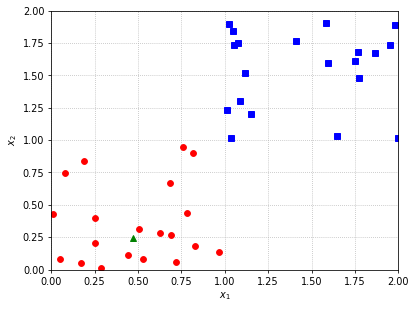

In [2]:
X1 = generate_random_points(20, 0, 1)
X2 = generate_random_points(20, 1, 2)

new_point = generate_random_points(1, 0, 2)

plot = init_plot([0, 2], [0, 2])  # [0, 2] x [0, 2]

plot.plot(*X1.T, 'ro', *X2.T, 'bs', *new_point.T, 'g^');

In [3]:
class NearestNeighbor():
  """Nearest Neighbor Classifier"""

  def __init__(self, distance=0):
    """Set distance definition: 0 - L1, 1 - L2"""
    if distance == 0:
      self.distance = np.abs     # absolute value
    elif distance == 1:
      self.distance = np.square  # square root
    else:
      raise Exception("Distance not defined.")


  def train(self, x, y):
    """Train the classifier (here simply save training data)

    x -- feature vectors (N x D)
    y -- labels (N x 1)
    """
    self.x_train = x
    self.y_train = y


  def predict(self, x):
    """Predict and return labels for each feature vector from x

    x -- feature vectors (N x D)
    """
    predictions = []  # placeholder for N labels

    # loop over all test samples
    for x_test in x:
      # array of distances between current test and all training samples
      distances = np.sum(self.distance(self.x_train - x_test), axis=1)

      # get the closest one
      min_index = np.argmin(distances)

      # add corresponding label
      predictions.append(self.y_train[min_index])

    return predictions

In [25]:
class Analysis():
  """Apply NearestNeighbor to generated (uniformly) test samples."""

  def __init__(self, *x, distance):
    """Generate labels and initilize classifier

    x -- feature vectors arrays
    distance -- 0 for L1, 1 for L2    
    """
    # get number of classes
    self.nof_classes = len(x)

    # create lables array
    # np.ones creates an array of given shape filled with 1 of given type
    # we apply consecutive integer numbers as class labels
    # ravel return flatten array
    y = [i * np.ones(_x.shape[0], dtype=int) for i, _x in enumerate(x)]
    y = np.array(y).ravel()

    # save training samples to plot them later
    self.x_train = x

    # merge feature vector arrays for NearestNeighbor
    x = np.concatenate(x, axis=0)

    # train classifier
    self.nn = NearestNeighbor(distance)
    self.nn.train(x, y)


  def prepare_test_samples(self, low=0, high=2, step=0.01):
    """Generate a grid with test points (from low to high with step)"""
    # remember range
    self.range = [low, high]

    # start with grid of points from [low, high] x [low, high]
    grid = np.mgrid[low:high+step:step, low:high+step:step]

    # convert to an array of 2D points
    self.x_test = np.vstack([grid[0].ravel(), grid[1].ravel()]).T


  def analyse(self):
    """Run classifier on test samples and split them according to labels."""

    # find labels for test samples 
    self.y_test = self.nn.predict(self.x_test)

    self.classified = []  # [class I test points, class II test ...]

    # loop over available labels
    for label in range(self.nof_classes):
      # if i-th label == current label -> add test[i]
      class_i = np.array([self.x_test[i] \
                          for i, l in enumerate(self.y_test) \
                          if l == label])
      self.classified.append(class_i)


  def plot(self, t=''):
    """Visualize the result of classification"""
    plot = init_plot(self.range, self.range)
    plot.set_title(t)
    plot.grid(False)

    # plot training samples
    for i, x in enumerate(self.x_train):
      plot.plot(*x.T, mpl_colors[i] + 'o')

    # plot test samples
    for i, x in enumerate(self.classified):
      plot.plot(*x.T, mpl_colors[i] + ',')

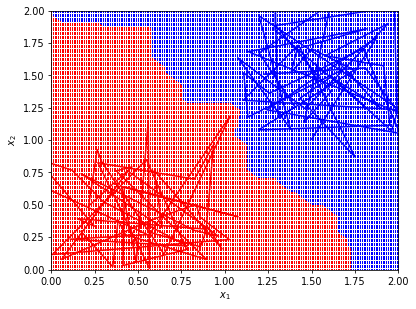

In [26]:
l1 = Analysis(X1, X2, distance=0)
l1.prepare_test_samples()
l1.analyse()
l1.plot()

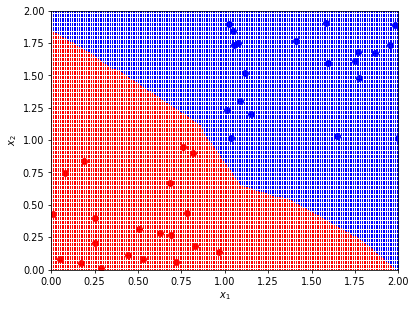

In [6]:
l2 = Analysis(X1, X2, distance=1)
l2.prepare_test_samples()
l2.analyse()
l2.plot()

In [7]:
def generate4(n=50):
  """Generate 4 sets of random points."""

  # points from [0, 1] x [0, 1]
  X1 = generate_random_points(n, 0, 1)
  # points from [1, 2] x [1, 2]
  X2 = generate_random_points(n, 1, 2)
  # points from [0, 1] x [1, 2]
  X3 = np.array([[x, y+1] for x,y in generate_random_points(n, 0, 1)])
  # points from [1, 2] x [0, 1]
  X4 = np.array([[x, y-1] for x,y in generate_random_points(n, 1, 2)])

  return X1, X2, X3, X4

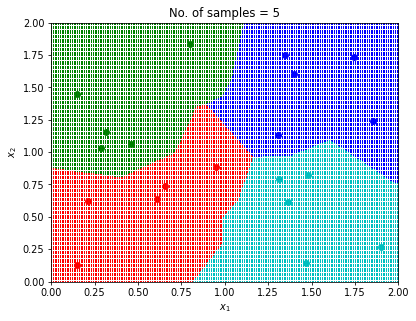

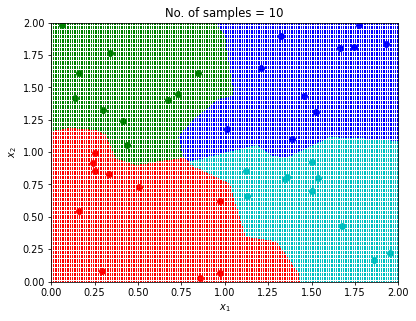

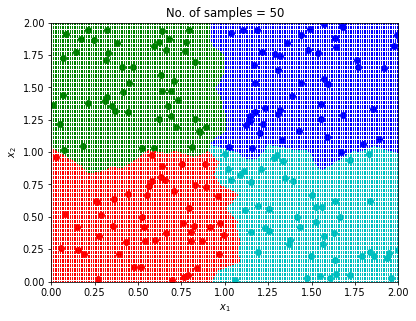

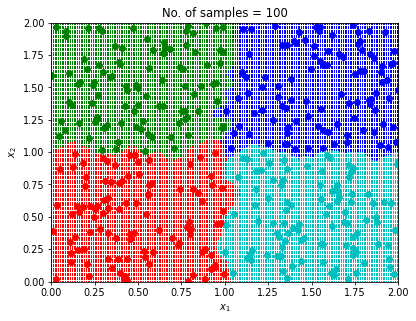

In [8]:
# loop over no. of training samples
for n in (5, 10, 50, 100):
  # generate 4 sets of random points (each one with n samples)
  # unpack them when passing to Analysis
  c4 = Analysis(*generate4(n), distance=1)
  c4.prepare_test_samples()
  c4.analyse()
  c4.plot("No. of samples = {}".format(n))

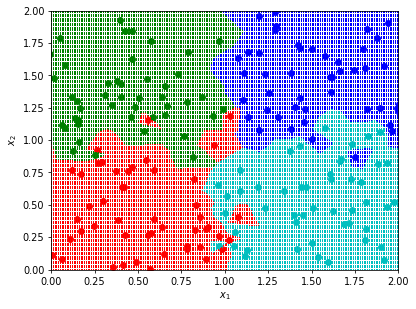

In [9]:
# generate 4 classes of 2D points
X1, X2, X3, X4 = generate4()

# add some noise by applying gaussian to every point coordinates
noise = lambda x, y: [np.random.normal(x, 0.1), np.random.normal(y, 0.1)]

X1 = np.array([noise(x, y) for x, y in X1])
X2 = np.array([noise(x, y) for x, y in X2])
X3 = np.array([noise(x, y) for x, y in X3])
X4 = np.array([noise(x, y) for x, y in X4])

# perform analysis
c4 = Analysis(X1, X2, X3, X4, distance=1)
c4.prepare_test_samples()
c4.analyse()
c4.plot()

In [10]:
accuracy = 0

# loop over (sample, reconstructed label)
for sample, label in zip(c4.x_test, c4.y_test):
  # determine true label
  if sample[0] < 1 and sample[1] < 1:
    true_label = 0
  elif sample[0] > 1 and sample[1] > 1:
    true_label = 1
  elif sample[0] < 1 and sample[1] > 1:
    true_label = 2
  else:
    true_label = 3

  if true_label == label: accuracy += 1

accuracy /= len(c4.x_test)

print(accuracy)

0.9063389520061385


In [11]:
class kNearestNeighbors(NearestNeighbor):
  """k-Nearest Neighbor Classifier"""


  def __init__(self, k=1, distance=0):
    """Set distance definition: 0 - L1, 1 - L2"""
    super().__init__(distance)
    self.k = k


  def predict(self, x):
    """Predict and return labels for each feature vector from x

    x -- feature vectors (N x D)
    """
    predictions = []  # placeholder for N labels

    # no. of classes = max label (labels starts from 0)
    nof_classes = np.amax(self.y_train) + 1

    # loop over all test samples
    for x_test in x:
      # array of distances between current test and all training samples
      distances = np.sum(self.distance(self.x_train - x_test), axis=1)

      # placeholder for labels votes
      votes = np.zeros(nof_classes, dtype=int)

      # find k closet neighbors and vote
      # argsort returns the indices that would sort an array
      # so indices of nearest neighbors
      # we take self.k first
      for neighbor_id in np.argsort(distances)[:self.k]:
        # this is a label corresponding to one of the closest neighbor
        neighbor_label = self.y_train[neighbor_id]
        # which updates votes array
        votes[neighbor_label] += 1

      # predicted label is the one with most votes
      predictions.append(np.argmax(votes))

    return predictions

In [12]:
class kAnalysis(Analysis):
  """Apply kNearestNeighbor to generated (uniformly) test samples."""

  def __init__(self, *x, k=1, distance=1):
    """Generate labels and initilize classifier

    x -- feature vectors arraysL
    k -- number of nearest neighbors
    distance -- 0 for L1, 1 for L2    
    """
    # get number of classes
    self.nof_classes = len(x)

    # create lables array
    y = [i * np.ones(_x.shape[0], dtype=int) for i, _x in enumerate(x)]
    y = np.array(y).ravel()

    # save training samples to plot them later
    self.x_train = x

    # merge feature vector arrays for NearestNeighbor
    x = np.concatenate(x, axis=0)

    # train classifier (knn this time)
    self.nn = kNearestNeighbors(k, distance)
    self.nn.train(x, y)

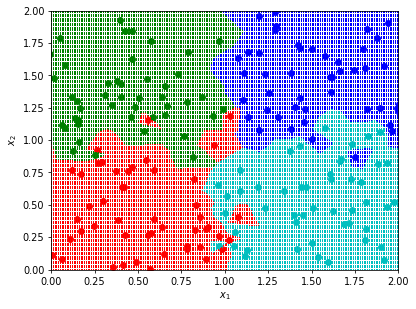

In [13]:
# apply kNN with k=1 on the same set of training samples
knn = kAnalysis(X1, X2, X3, X4, k=1, distance=1)
knn.prepare_test_samples()
knn.analyse()
knn.plot()

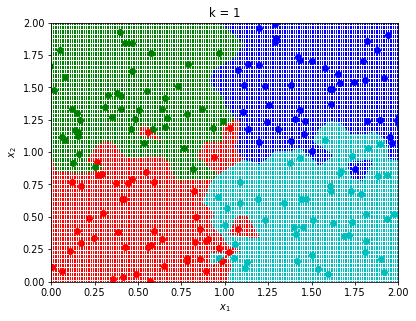

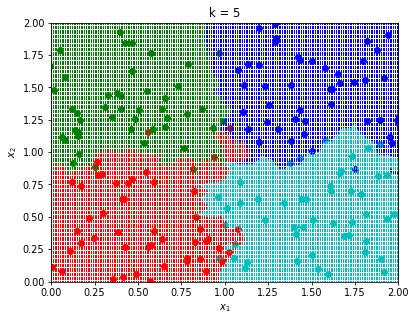

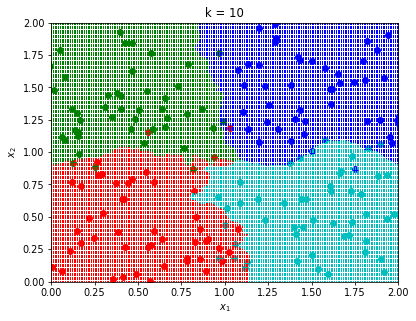

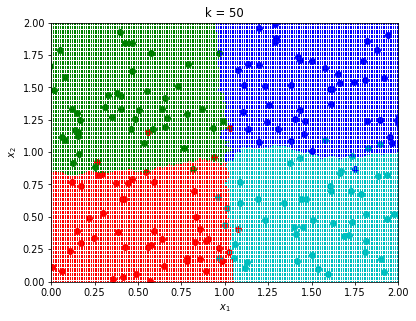

In [14]:
# training size = 50
# let's check a few values between 1 and 50
for k in (1, 5, 10, 50):
  knn = kAnalysis(X1, X2, X3, X4, k=k, distance=1)
  knn.prepare_test_samples()
  knn.analyse()
  knn.plot("k = {}".format(k))